<a href="https://colab.research.google.com/github/dowrave/Tensorflow_Basic/blob/main/220513_Tensorflow_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eager Execution(즉시 실행)
- 그래프를 생성하지 않고 함수를 바로 실행하는 명령형 프로그래밍 환경
- 나중에 실행하기 위한 그래프를 생성하는 대신 계산값을 바로 알려주는 연산
- 장점으로는
  - 직관적인 인터페이스
  - 손쉬운 디버깅
  - 자연스러운 흐름 제어
- 등이 있다.

In [1]:
import tensorflow as tf
import cProfile

In [2]:
tf.executing_eagerly() # 즉시 실행 여부 : 기본 True

True

In [3]:
x = [[2.]]
m = tf.matmul(x, x)
print(m) 

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


- tf.Tensor 객체를 조회했을 때, '객체다'라고 알려주면서 동시에 그 내부 값도 같이 보여준다.

In [4]:
a = tf.constant([[1, 2,],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [5]:
b = tf.add(a, 1) # broadcasting
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [6]:
print(a*b) # elementwise

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [7]:
import numpy as np

c = np.multiply(a,b) # 텐서는 넘파이의 연산도 지원한다
print(c)

[[ 2  6]
 [12 20]]


In [8]:
print(a.numpy()) # 텐서에서 넘파이 값 얻기

[[1 2]
 [3 4]]


### 즉시 실행의 가장 큰 이점 : 모델 실행하면서 호스트 언어의 모든 기능을 활용할 수 있다

In [9]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num) # 스칼라값 -> 텐서 변환 시 텐서는 0차원 + 스칼라값을 갖는다.
  '''max_num = 20으로 하면 안되나? -> 된다.'''
  # max_num = 20
  for num in range(1, max_num.numpy() + 1): # max_num.numpy() : 20의 스칼라값, numpy값임
    num = tf.constant(num)
    if int(num % 3) == 0 and int (num % 5) == 0:
      print("FizzBuzz")
    elif int(num % 3) == 0:
      print("Fizz")
    elif int(num % 5) == 0:
      print("Buzz")
    else:
      print(num.numpy())
    counter += 1

In [10]:
type(tf.convert_to_tensor(20).numpy())

numpy.int32

In [11]:
fizzbuzz(20)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz
16
17
Fizz
19
Buzz


## 즉시 훈련
- 그래디언트 계산 추적 시 `tf.GradientTape`을 사용한다.
  - 모든 정방향 연산은 `Tape`에 기록된다. 이 후 `Tape`를 거꾸로 돌려 그래디언트를 계산한 뒤, `Tape`를 폐기한다. 
  - 특정 `tf.GradientTape`는 오직 하나의 그래디언트만을 계산하고, 부가적인 호출은 런타임에러를 발생시킨다.

In [12]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad) # 왜 2일까?

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


## 모델 훈련 : 표준 MNIST

In [13]:
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis] / 255, tf.float32),
     tf.cast(mnist_labels, tf.int64))
    )
dataset = dataset.shuffle(1000).batch(32)

11501568/11490434 [==============================] - 0s 0us/step


In [14]:
mnist_model = tf.keras.Sequential([
                                   tf.keras.layers.Conv2D(16, [3,3], activation = 'relu', input_shape = (None, None, 1),
                                                        ),
                                   tf.keras.layers.Conv2D(16, [3, 3], activation = 'relu',
                                                          ),
                                   tf.keras.layers.GlobalAveragePooling2D(),
                                   tf.keras.layers.Dense(10)
                                   
])

In [15]:
# 즉시 실행 : 훈련 없이 모델 사용 및 결과 점검 가능 - 근데 이게 의미가 있나?
for images, labels in dataset.take(1):
  print(mnist_model(images[0:1]).numpy())

[[ 0.0240368  -0.00173725  0.06099878  0.03962428  0.08952959 -0.17466584
  -0.02516137  0.01781385  0.03090387 -0.02970311]]


In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
loss_history = []

#### 학습과정
1. 순전파
2. 오차함수(`SparseCategoricalCrossentropy`) 계산 -> `loss_value`에 담김
3. `loss_value`의 평균을 `loss_history`에 추가. (기록용)
4. `loss_value`의 값은 `gradient` 계산에 이용됨.
  - `model.trainable_variables`는 가중치, 바이어스 값이겠죠?
  - `tape.gradient(a, b)` : a : 손실함수 값, b : 학습가능한 파라미터 
    - 사용법은 거의 고정되어 있을 듯?
5. `optimizer.apply_gradients` : 앞의 grads 값은 위에서 계산된 값, 뒤의 trainable_variables는 원래 가중치 값 -> 여기서 최종 가중치 갱신이 일어남



In [17]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training = True)

    tf.debugging.assert_equal(logits.shape, (32, 10))  # 이거 assert문으로 쓸 수도 있을 거임
    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [18]:
def train():
  for epoch in range(3):
    for (batcn, (image, labels)) in enumerate(dataset):
      train_step(images, labels) # 위에서 정의한 함수
    print(f"에포크 {epoch} 종료")

In [19]:
train()

에포크 0 종료
에포크 1 종료
에포크 2 종료


Text(0, 0.5, 'loss [entropy')

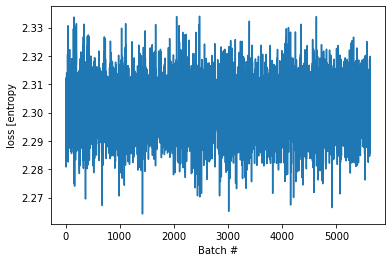

In [20]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('loss [entropy')

## 변수와 옵티마이저
- `tf.Variable` 객체는 학습 동안 변경된 `tf.Tensor` 값을 저장한다. 
- 모델 파라미터는 클래스 인스턴스 변수로 캡슐화할 수 있다.
- `tf.Variable`을 `tf.GradientTape`와 함께 저장한다

In [26]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name = 'bias')
  
  def call(self, inputs):
    return inputs * self.W + self.B

NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES]) # (2000,) 
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise 

# 최적화할 손실 함수
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error)) # tf.reduce_mean() : 텐서 전체의 값의 평균을 냄. (a,b) 형태로 ,b를 지정해 axis의 평균을 낼 수도 있음

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets) 
  return tape.gradient(loss_value, [model.W, model.B]) # tape와 variable 값을 함께 저장해둠

In [30]:
# 모델 -> 손실함수 미분 -> 변수 업데이트
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

print("Initial Loss : {:.3f}".format(loss(model, training_inputs, training_outputs)))

for i in range(300):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("스텝 {:03d}에서의 손실 : {:.3f}".format(i, loss(model, training_inputs, training_outputs)))
  
print("최종 손실 : {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial Loss : 69.246
스텝 000에서의 손실 : 66.524
스텝 020에서의 손실 : 30.033
스텝 040에서의 손실 : 13.866
스텝 060에서의 손실 : 6.702
스텝 080에서의 손실 : 3.527
스텝 100에서의 손실 : 2.120
스텝 120에서의 손실 : 1.497
스텝 140에서의 손실 : 1.220
스텝 160에서의 손실 : 1.098
스텝 180에서의 손실 : 1.043
스텝 200에서의 손실 : 1.019
스텝 220에서의 손실 : 1.008
스텝 240에서의 손실 : 1.004
스텝 260에서의 손실 : 1.002
스텝 280에서의 손실 : 1.001
최종 손실 : 1.000
W = 3.002971887588501, B = 2.0329818725585938


## 즉시 실행에서 상태를 위한 객체 사용

In [31]:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("gpu:0"):
    print("GPU Available")
    v = tf.Variable(tf.random.normal([1000, 1000]))
    v = None

GPU Available


## 객체 기반의 저장
- `tf.train.Checkpoint`는 `tf.Variable`을 체크포인트 파일로 저장 및 복구할 수 있음

In [32]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [33]:
x.assign(2.) # x에 2라는 새로운 값 할당 및 저장
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [34]:
x.assign(11.) # 저장한 뒤 값 변경

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
print(x) # numpy 값 2로 돌아온 걸 확인할 수 있음

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


### 모델 저장 & 읽기 시에도 그냥 저장만 하면 됨

In [36]:
import os

model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, [3,3], activation = 'relu'),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

# Checkpoint 파일로 저장 및 불러오는 파트
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
root = tf.train.Checkpoint(optimizer = optimizer,  
                           model = model) # Checkpoint는 optimizer와 model을 저장한다.

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 객체 지향형 지표
`tf.keras.metrics`는 객체로 저장된다. 새로운 데이터를 이 객체에 전달해 지표를 수정하고 `tf.keras.metrics.result`를 이용해 그 결과를 얻는다.

In [42]:
m = tf.keras.metrics.Mean("loss")
m(0) # numpy = 0
m(5) # numpy = 2.5
m.result()  # numpy = 2.5
m([8, 9]) # numpy = 5.5
m.result()
# 근데 이 예제들에서 m이랑 m.result()랑 차이를 몰?루겠네요

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

## 서머리와 텐서보드
- 텐서보드 : 훈련 과정에서 모델을 파악, 디버깅, 최적화하기 위해 사용하는 시각화 도구
  - 텐서보드는 프로그램 실행 동안 작성된 서머리 이벤트를 사용한다.

- 서머리 정보 기록을 위해 `tf.summary`를 이용한다.

In [44]:
logdir = "./tb"
writer = tf.summary.create_file_writer(logdir)

with writer.as_default(): # 또는 반복 전에 writer.set_as_default() 호출
  for i in range(1000):
    step = i + 1
    loss = 1 - 0.001 * step 
    if step % 100 == 0: # 100번째 step 마다
      tf.summary.scalar('손실', loss, step = step) # 손실을 기록한다 

In [46]:
!ls tb/

events.out.tfevents.1652427299.4235d1ab24bb.75.0.v2


## 자동 미분 - 고급편

### 동적 모델
- `tf.GradientTape`는 동적 모델에서도 사용가능하다

In [47]:
def line_serach_step(fn, init_x, rate = 1.0):
  with tf.GradientTape() as tape:
    # 변수는 자동 기록되나, 텐서는 사용자가 스스로 확인해야 함
    tape.watch(init_x)
    value = fn(init_x)

  grad = tape.gradient(value, init_x)
  grad_norm= tf.reduce_sum(grad * grad)
  init_value = value
  while value > init_value - rate * grad_norm:
    x = init_x - rate * grad
    value = fn(x)
    rate /= 2.0
  return x, value

### 사용자 정의 그래디언트
- 그래디언트를 Override하는 가장 쉬운 방법
- 다음 예제는 역전파 과정에서 Gradient의 Norm을 Clipping하는 가장 쉬운 방법

#### Clip?
- Gradient Exploding을 방지하는 방법.
- 그래디언트 값이 임계치 값을 넘어가면 그 값을 (통상적으로 L2) Norm으로 나눠주는 방식이다.

In [48]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(dresult):
    return [tf.clip_by_norm(dresult, norm), None]
  return y, grad_fn

In [53]:
# 사용자 정의 그래디언트는 수치적으로 안정된 그래디언트를 제공하기 위해 사용된다.
def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)

  return tape.gradient(value, x)

In [54]:
grad_log1pexp(tf.constant(0.)).numpy() #x=0에서 잘 동작

0.5

In [56]:
grad_log1pexp(tf.constant(100.)).numpy() # x=100에서 수치적으로 불안정해서 실패

nan

In [63]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

In [64]:
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [65]:
grad_log1pexp(tf.constant(100.)).numpy()

1.0

## 성능
- 즉시 실행에서 계산은 자동으로 GPU로 분배됨.
- 사용자가 제어하고 싶다면 해당 부분을 `tf.device('/gpu:0')`으로 감싸시오

In [71]:
import time

def measure(x, steps):
  tf.matmul(x,x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x) # 행렬 곱셈 완료 전에 결과를 반환할 수 있다.
  _ = x.numpy() # 대기열에 추가된 모든 연산이 완료될 것임을 보장하는 호출
                  # 이 결과는 호스트 메모리에 복사될 것이고, matmul 연산 시간보다 조금 더 연산 시간이 소요됨
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("{} Size Matrix multiplied itself {} time".format(shape, steps))


# CPU 실행
with tf.device("/cpu:0"):
  print("CPU : {} sec".format(measure(tf.random.normal(shape), steps))) # 16.44sec

# GPU
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU : {} sec".format(measure(tf.random.normal(shape), steps))) # 0.30 sec
else:
  print("NO GPU")

(1000, 1000) Size Matrix multiplied itself 200 time
CPU : 16.440157651901245 sec
GPU : 0.3024556636810303 sec


`tf.tensor` 객체는 연산을 수행할 다른 디바이스로 복사 될 수 있다.

In [73]:
if tf.config.experimental.list_physical_devices("GPU"):
  x = tf.random.normal([10, 10])

  # 텐서 객체에 .gpu(), .cpu()메서드를 붙이는 것 만으로 수행할 장치를 정할 수 있음
  x_gpu0 = x.gpu() 
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)
  _ = tf.matmul(x_gpu0, x_gpu0)